<a href="https://colab.research.google.com/github/wai-ming-chan/fed_avg/blob/main/FedAvg_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo program to train MNIST with Pytorch (Federated Averging)

Reference: [https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029)

In [1]:
###############################
##### importing libraries #####
###############################

import os
import random
from tqdm import tqdm
import numpy as np
import math

import torch, torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   
torch.backends.cudnn.benchmark=True

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

#-----------------------------------------------------------------------
# libraries for pyTorch model Visualization
! pip install -q torchview
! pip install -q -U graphviz

# import torchvision

from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')
#-----------------------------------------------------------------------
! pip install -q torch-summary
from torchsummary import summary


### Hyper-parameters setting

In [2]:
class system_args:

    # Set GPU or CPU device. If GPU is available, we use it to speed up the training
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        print('[GPU mode] device: ', device)
    else:
        print('[CPU mode] device: ', device)
    verbose = 1

    num_clients = 100                     # Total number of clients
    num_rounds = 200                      # number of communication rounds (num of server epoches)
    # bs = 64                               # batch size
    # epochs = 100                          
    lr = 1e-3                             # learning rate
    
    frac_C = 0.1        # C, fraction of clients that perform computation on each round
    local_epoches = 1  # E, number of training passes each client makes over its local dataset on each round
    local_bs = 10       # B, the local minibatch size used for the client updates.
    iid = True          # IID or Non-IID data partition 

    num_selected = math.ceil(frac_C * num_clients)



[GPU mode] device:  cuda


### Helper functions for Federated Training

In [3]:
def client_update(client_model, optimizer, train_loader, system_args):
    model.train()   # tells your model that you are training the model (model.train()	vs model.eval())
    for e in range(system_args.local_epoches):
        for batch_idx, (data, target) in enumerate(train_loader):
            if system_args.device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = client_model(data)       # make a prediction
            loss = F.cross_entropy(output, target) # compute the loss value
            # loss = F.nll_loss(output, target) # compute the loss value
            # loss = F.nll_loss(output, target) # compute the loss value
            optimizer.zero_grad()             # set our gradient to zero
            loss.backward()                   # gradient descent
            optimizer.step()                  # update our weights and biases
    return loss.item()



def server_aggregate(global_model, client_models, system_args):
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)

    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict())


def test(global_model, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()  # sets model in evaluation (inference) mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if system_args.device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       157,000
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       40,200
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0


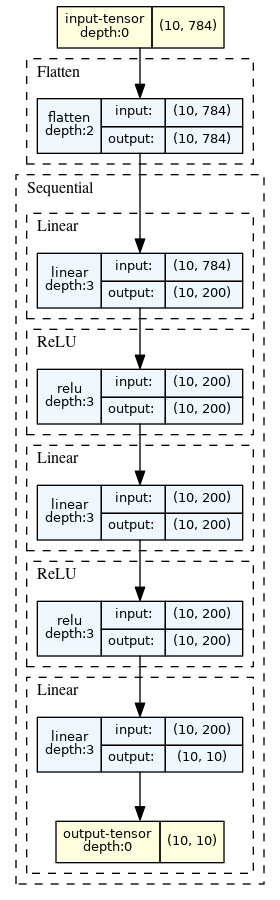

In [4]:
# setup our model now.

# Model 1: 2NN
class MNIST_2NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_2NN = MNIST_2NN().to(system_args.device)
summary(model_2NN, input_size=(1,28*28), batch_size=system_args.local_bs)


model_graph = draw_graph(
  model_2NN, 
  input_size=(system_args.local_bs,28*28), 
  graph_name='my2NN',
  hide_inner_tensors=True,
  hide_module_functions=False,
  expand_nested=True,
  roll=True, # rolls recursive models
  save_graph=True
)
model_graph.visual_graph
#-----------------------------------------------------------------------

### Loading dataset


In [5]:
# grab MNIST data with torchvision datasets
## We can tell Pytorch how to manipulate the dataset by giving details.
##
### root: Where to store the data. We are storing it in data directory.
### train: Whether to grab training dataset or testing dataset. 
###         Given True value, training_data is a training dataset from MNIST. 
###         On the other hand, test_data is a testing dataset from MNIST.
### download: Whether to download if data is not already in root. We passed True to download the dataset.
### transform: What to do with data. We are converting our images of handwritten digits into Pytorch tensors so that we can train our model.

# Loading MNIST dataset using torchvision.datasets
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    training_data, 
    [int(training_data.data.shape[0] / system_args.num_clients) for _ in range(system_args.num_clients)]
)
    
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=system_args.local_bs, shuffle=True) for x in traindata_split]

# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=system_args.local_bs, 
        shuffle=True
)


# check the dimension of data
print(training_data)
print('training data size: ', len(training_data) )
print('test data size: ', len(test_dataset) )
print(training_data[0][0].shape)
print(training_data[0][0].squeeze().shape)
# plt.imshow(training_data[len(training_data)-1][0].squeeze(), cmap="gray");
# print('label: ', training_data[len(training_data)-1][1])




Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
training data size:  60000
test data size:  10000
torch.Size([1, 28, 28])
torch.Size([28, 28])


### Training the model

In [ ]:
############################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
# global_model =  VGG('VGG19').cuda()
global_model =  MNIST_2NN().to(system_args.device)

############## client models ##############
# client_models = [ VGG('VGG19').cuda() for _ in range(num_selected)]
client_models = [ MNIST_2NN().to(system_args.device) for _ in range(system_args.num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=system_args.lr) for model in client_models]

###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(system_args.num_rounds):
    # select random clients
    client_idx = np.random.permutation(system_args.num_clients)[:system_args.num_selected]
    # client update
    loss = 0
    for i in tqdm(range(system_args.num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], system_args)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models, system_args)
    
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / system_args.num_selected, test_loss, acc))

100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


0-th round
average train loss 2.3 | test loss 2.3 | test acc: 0.105


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1-th round
average train loss 2.3 | test loss 2.3 | test acc: 0.115


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


2-th round
average train loss 2.3 | test loss 2.3 | test acc: 0.124


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


3-th round
average train loss 2.29 | test loss 2.3 | test acc: 0.135


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


4-th round
average train loss 2.29 | test loss 2.29 | test acc: 0.152


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


5-th round
average train loss 2.3 | test loss 2.29 | test acc: 0.163


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


6-th round
average train loss 2.29 | test loss 2.29 | test acc: 0.177


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


7-th round
average train loss 2.29 | test loss 2.29 | test acc: 0.188


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


8-th round
average train loss 2.3 | test loss 2.29 | test acc: 0.198


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


9-th round
average train loss 2.29 | test loss 2.28 | test acc: 0.213


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


10-th round
average train loss 2.29 | test loss 2.28 | test acc: 0.228


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


11-th round
average train loss 2.28 | test loss 2.28 | test acc: 0.237


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


12-th round
average train loss 2.27 | test loss 2.28 | test acc: 0.254


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


13-th round
average train loss 2.28 | test loss 2.28 | test acc: 0.274


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


14-th round
average train loss 2.28 | test loss 2.27 | test acc: 0.290


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


15-th round
average train loss 2.28 | test loss 2.27 | test acc: 0.309


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


16-th round
average train loss 2.28 | test loss 2.27 | test acc: 0.328


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


17-th round
average train loss 2.27 | test loss 2.27 | test acc: 0.342


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


18-th round
average train loss 2.27 | test loss 2.27 | test acc: 0.356


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


19-th round
average train loss 2.26 | test loss 2.26 | test acc: 0.367


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


20-th round
average train loss 2.27 | test loss 2.26 | test acc: 0.379


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


21-th round
average train loss 2.26 | test loss 2.26 | test acc: 0.386


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


22-th round
average train loss 2.26 | test loss 2.26 | test acc: 0.398


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


23-th round
average train loss 2.26 | test loss 2.25 | test acc: 0.410


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


24-th round
average train loss 2.25 | test loss 2.25 | test acc: 0.421


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


25-th round
average train loss 2.25 | test loss 2.25 | test acc: 0.432


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


26-th round
average train loss 2.25 | test loss 2.25 | test acc: 0.441


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


27-th round
average train loss 2.23 | test loss 2.24 | test acc: 0.452


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


28-th round
average train loss 2.22 | test loss 2.24 | test acc: 0.459


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


29-th round
average train loss 2.24 | test loss 2.24 | test acc: 0.466


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


30-th round
average train loss 2.23 | test loss 2.23 | test acc: 0.476


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


31-th round
average train loss 2.24 | test loss 2.23 | test acc: 0.481


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


32-th round
average train loss 2.23 | test loss 2.23 | test acc: 0.485


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


33-th round
average train loss 2.24 | test loss 2.22 | test acc: 0.489


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


34-th round
average train loss 2.21 | test loss 2.22 | test acc: 0.493


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


35-th round
average train loss 2.22 | test loss 2.22 | test acc: 0.501


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


36-th round
average train loss 2.23 | test loss 2.21 | test acc: 0.507


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


37-th round
average train loss 2.22 | test loss 2.21 | test acc: 0.511


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


38-th round
average train loss 2.2 | test loss 2.21 | test acc: 0.515


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


39-th round
average train loss 2.22 | test loss 2.2 | test acc: 0.522


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


40-th round
average train loss 2.19 | test loss 2.2 | test acc: 0.527


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


41-th round
average train loss 2.2 | test loss 2.19 | test acc: 0.533


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


42-th round
average train loss 2.19 | test loss 2.19 | test acc: 0.544


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


43-th round
average train loss 2.18 | test loss 2.18 | test acc: 0.549


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


44-th round
average train loss 2.18 | test loss 2.18 | test acc: 0.553


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


45-th round
average train loss 2.18 | test loss 2.17 | test acc: 0.559


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


46-th round
average train loss 2.19 | test loss 2.17 | test acc: 0.567


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.31it/s]


47-th round
average train loss 2.15 | test loss 2.16 | test acc: 0.570


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


48-th round
average train loss 2.17 | test loss 2.16 | test acc: 0.572


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


49-th round
average train loss 2.14 | test loss 2.15 | test acc: 0.581


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


50-th round
average train loss 2.12 | test loss 2.15 | test acc: 0.582


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


51-th round
average train loss 2.16 | test loss 2.14 | test acc: 0.589


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


52-th round
average train loss 2.15 | test loss 2.13 | test acc: 0.592


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


53-th round
average train loss 2.16 | test loss 2.13 | test acc: 0.596


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


54-th round
average train loss 2.13 | test loss 2.12 | test acc: 0.601


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


55-th round
average train loss 2.12 | test loss 2.11 | test acc: 0.605


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


56-th round
average train loss 2.13 | test loss 2.1 | test acc: 0.610


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


57-th round
average train loss 2.11 | test loss 2.1 | test acc: 0.611


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


58-th round
average train loss 2.09 | test loss 2.09 | test acc: 0.614


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


59-th round
average train loss 2.1 | test loss 2.08 | test acc: 0.615


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


60-th round
average train loss 2.09 | test loss 2.07 | test acc: 0.621


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


61-th round
average train loss 2.09 | test loss 2.06 | test acc: 0.624


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


62-th round
average train loss 2.06 | test loss 2.05 | test acc: 0.625


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


63-th round
average train loss 2.04 | test loss 2.04 | test acc: 0.625


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


64-th round
average train loss 2.02 | test loss 2.03 | test acc: 0.629


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


65-th round
average train loss 2.05 | test loss 2.02 | test acc: 0.633


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


66-th round
average train loss 1.99 | test loss 2.01 | test acc: 0.635


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


67-th round
average train loss 2.03 | test loss 2 | test acc: 0.638


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


68-th round
average train loss 1.99 | test loss 1.99 | test acc: 0.638


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


69-th round
average train loss 1.98 | test loss 1.98 | test acc: 0.642


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


70-th round
average train loss 1.94 | test loss 1.97 | test acc: 0.644


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


71-th round
average train loss 1.98 | test loss 1.95 | test acc: 0.645


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


72-th round
average train loss 1.92 | test loss 1.94 | test acc: 0.649


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


73-th round
average train loss 1.98 | test loss 1.93 | test acc: 0.646


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


74-th round
average train loss 1.97 | test loss 1.92 | test acc: 0.649


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.31it/s]


75-th round
average train loss 1.93 | test loss 1.9 | test acc: 0.648


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


76-th round
average train loss 1.95 | test loss 1.89 | test acc: 0.649


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


77-th round
average train loss 1.87 | test loss 1.87 | test acc: 0.649


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


78-th round
average train loss 1.84 | test loss 1.86 | test acc: 0.653


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


79-th round
average train loss 1.85 | test loss 1.84 | test acc: 0.655


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


80-th round
average train loss 1.89 | test loss 1.83 | test acc: 0.656


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


81-th round
average train loss 1.84 | test loss 1.81 | test acc: 0.655


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


82-th round
average train loss 1.85 | test loss 1.79 | test acc: 0.658


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


83-th round
average train loss 1.75 | test loss 1.78 | test acc: 0.659


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


84-th round
average train loss 1.71 | test loss 1.76 | test acc: 0.659


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


85-th round
average train loss 1.74 | test loss 1.74 | test acc: 0.662


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


86-th round
average train loss 1.71 | test loss 1.72 | test acc: 0.663


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


87-th round
average train loss 1.67 | test loss 1.71 | test acc: 0.662


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


88-th round
average train loss 1.74 | test loss 1.69 | test acc: 0.664


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


89-th round
average train loss 1.64 | test loss 1.67 | test acc: 0.667


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


90-th round
average train loss 1.64 | test loss 1.65 | test acc: 0.669


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


91-th round
average train loss 1.63 | test loss 1.63 | test acc: 0.671


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


92-th round
average train loss 1.62 | test loss 1.61 | test acc: 0.674


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


93-th round
average train loss 1.61 | test loss 1.59 | test acc: 0.675


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


94-th round
average train loss 1.62 | test loss 1.57 | test acc: 0.678


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


95-th round
average train loss 1.53 | test loss 1.56 | test acc: 0.678


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


96-th round
average train loss 1.53 | test loss 1.54 | test acc: 0.679


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


97-th round
average train loss 1.57 | test loss 1.52 | test acc: 0.679


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


98-th round
average train loss 1.43 | test loss 1.5 | test acc: 0.684


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


99-th round
average train loss 1.48 | test loss 1.48 | test acc: 0.686


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


100-th round
average train loss 1.48 | test loss 1.46 | test acc: 0.688


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


101-th round
average train loss 1.42 | test loss 1.44 | test acc: 0.692


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


102-th round
average train loss 1.45 | test loss 1.42 | test acc: 0.695


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


103-th round
average train loss 1.45 | test loss 1.4 | test acc: 0.702


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


104-th round
average train loss 1.45 | test loss 1.38 | test acc: 0.709


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


105-th round
average train loss 1.44 | test loss 1.36 | test acc: 0.711


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


106-th round
average train loss 1.29 | test loss 1.34 | test acc: 0.715


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


107-th round
average train loss 1.39 | test loss 1.33 | test acc: 0.719


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


108-th round
average train loss 1.29 | test loss 1.31 | test acc: 0.728


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


109-th round
average train loss 1.36 | test loss 1.29 | test acc: 0.734


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


110-th round
average train loss 1.32 | test loss 1.27 | test acc: 0.740


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


111-th round
average train loss 1.24 | test loss 1.25 | test acc: 0.743


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


112-th round
average train loss 1.28 | test loss 1.24 | test acc: 0.747


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


113-th round
average train loss 1.07 | test loss 1.22 | test acc: 0.751


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


114-th round
average train loss 1.25 | test loss 1.2 | test acc: 0.753


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


115-th round
average train loss 1.23 | test loss 1.19 | test acc: 0.759


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


116-th round
average train loss 1.21 | test loss 1.17 | test acc: 0.763


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


117-th round
average train loss 1.1 | test loss 1.16 | test acc: 0.765


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


118-th round
average train loss 1.09 | test loss 1.14 | test acc: 0.767


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


119-th round
average train loss 1.05 | test loss 1.13 | test acc: 0.774


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


120-th round
average train loss 1.09 | test loss 1.11 | test acc: 0.777


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


121-th round
average train loss 1.23 | test loss 1.1 | test acc: 0.780


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


122-th round
average train loss 1.11 | test loss 1.08 | test acc: 0.783


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


123-th round
average train loss 1.1 | test loss 1.07 | test acc: 0.786


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


124-th round
average train loss 0.992 | test loss 1.06 | test acc: 0.786


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


125-th round
average train loss 0.962 | test loss 1.04 | test acc: 0.788


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


126-th round
average train loss 0.982 | test loss 1.03 | test acc: 0.791


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


127-th round
average train loss 1.05 | test loss 1.02 | test acc: 0.794


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


128-th round
average train loss 1.01 | test loss 1 | test acc: 0.797


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


129-th round
average train loss 0.995 | test loss 0.993 | test acc: 0.799


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


130-th round
average train loss 1.08 | test loss 0.981 | test acc: 0.798


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


131-th round
average train loss 0.987 | test loss 0.97 | test acc: 0.798


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


132-th round
average train loss 1.06 | test loss 0.959 | test acc: 0.801


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


133-th round
average train loss 0.931 | test loss 0.948 | test acc: 0.802


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


134-th round
average train loss 0.925 | test loss 0.938 | test acc: 0.806


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


135-th round
average train loss 0.929 | test loss 0.927 | test acc: 0.806


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


136-th round
average train loss 1.04 | test loss 0.917 | test acc: 0.807


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


137-th round
average train loss 0.923 | test loss 0.907 | test acc: 0.810


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


138-th round
average train loss 0.887 | test loss 0.897 | test acc: 0.811


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


139-th round
average train loss 0.902 | test loss 0.888 | test acc: 0.811


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


140-th round
average train loss 0.809 | test loss 0.879 | test acc: 0.811


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


141-th round
average train loss 0.962 | test loss 0.87 | test acc: 0.812


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


142-th round
average train loss 0.877 | test loss 0.861 | test acc: 0.814


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


143-th round
average train loss 0.831 | test loss 0.852 | test acc: 0.817


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


144-th round
average train loss 0.824 | test loss 0.843 | test acc: 0.818


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


145-th round
average train loss 0.838 | test loss 0.835 | test acc: 0.818


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


146-th round
average train loss 0.774 | test loss 0.827 | test acc: 0.820


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


147-th round
average train loss 0.825 | test loss 0.819 | test acc: 0.821


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


148-th round
average train loss 0.941 | test loss 0.811 | test acc: 0.823


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


149-th round
average train loss 0.827 | test loss 0.804 | test acc: 0.822


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


150-th round
average train loss 0.895 | test loss 0.796 | test acc: 0.823


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


151-th round
average train loss 0.814 | test loss 0.789 | test acc: 0.825


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


152-th round
average train loss 0.883 | test loss 0.782 | test acc: 0.826


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


153-th round
average train loss 0.915 | test loss 0.776 | test acc: 0.826


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


154-th round
average train loss 0.817 | test loss 0.769 | test acc: 0.826


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


155-th round
average train loss 0.746 | test loss 0.763 | test acc: 0.826


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


156-th round
average train loss 0.81 | test loss 0.756 | test acc: 0.828


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


157-th round
average train loss 0.885 | test loss 0.75 | test acc: 0.831


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


158-th round
average train loss 0.768 | test loss 0.744 | test acc: 0.832


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


159-th round
average train loss 0.737 | test loss 0.737 | test acc: 0.832


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


160-th round
average train loss 0.851 | test loss 0.732 | test acc: 0.833


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


161-th round
average train loss 0.73 | test loss 0.726 | test acc: 0.834


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


162-th round
average train loss 0.843 | test loss 0.72 | test acc: 0.834


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


163-th round
average train loss 0.633 | test loss 0.714 | test acc: 0.836


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


164-th round
average train loss 0.811 | test loss 0.709 | test acc: 0.837


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


165-th round
average train loss 0.83 | test loss 0.704 | test acc: 0.838


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


166-th round
average train loss 0.703 | test loss 0.698 | test acc: 0.838


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


167-th round
average train loss 0.651 | test loss 0.693 | test acc: 0.839


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


168-th round
average train loss 0.783 | test loss 0.688 | test acc: 0.840


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


169-th round
average train loss 0.722 | test loss 0.683 | test acc: 0.840


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


170-th round
average train loss 0.724 | test loss 0.679 | test acc: 0.841


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


171-th round
average train loss 0.611 | test loss 0.674 | test acc: 0.842


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


172-th round
average train loss 0.614 | test loss 0.669 | test acc: 0.843


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


173-th round
average train loss 0.767 | test loss 0.665 | test acc: 0.843


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


174-th round
average train loss 0.623 | test loss 0.66 | test acc: 0.846


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


175-th round
average train loss 0.501 | test loss 0.656 | test acc: 0.846


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


176-th round
average train loss 0.699 | test loss 0.651 | test acc: 0.846


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


177-th round
average train loss 0.608 | test loss 0.647 | test acc: 0.847


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


178-th round
average train loss 0.776 | test loss 0.643 | test acc: 0.848


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


179-th round
average train loss 0.725 | test loss 0.639 | test acc: 0.846


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


180-th round
average train loss 0.704 | test loss 0.635 | test acc: 0.848


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


181-th round
average train loss 0.712 | test loss 0.631 | test acc: 0.849


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


182-th round
average train loss 0.742 | test loss 0.628 | test acc: 0.849


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


183-th round
average train loss 0.61 | test loss 0.624 | test acc: 0.850


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


184-th round
average train loss 0.589 | test loss 0.62 | test acc: 0.851


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


185-th round
average train loss 0.628 | test loss 0.616 | test acc: 0.852


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


186-th round
average train loss 0.633 | test loss 0.613 | test acc: 0.853


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


187-th round
average train loss 0.66 | test loss 0.609 | test acc: 0.853


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


188-th round
average train loss 0.695 | test loss 0.606 | test acc: 0.852


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


189-th round
average train loss 0.633 | test loss 0.602 | test acc: 0.854


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


190-th round
average train loss 0.678 | test loss 0.599 | test acc: 0.854


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


191-th round
average train loss 0.563 | test loss 0.596 | test acc: 0.855


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


192-th round
average train loss 0.665 | test loss 0.593 | test acc: 0.855


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


193-th round
average train loss 0.708 | test loss 0.59 | test acc: 0.855


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


### Some model hyperparameters setting

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(losses_train,label="train")
plt.plot(losses_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('figs/FedAvg_Loss.png')
plt.show()

plt.figure(figsize=(10,5))
plt.title("Test Data Accuracy")
plt.plot(acc_train,label="train")
plt.plot(acc_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.savefig('figs/FedAvg_Accuracy.png')
plt.legend()
plt.show()

